# Early CKD Detection

## Import Libraries

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

## Import Data

In [110]:
data = pd.read_csv(r'D:/Data science Notes/Python/Projects/Chronic Kidney Disease - Classification/kidney_disease.csv')
data=data.drop(columns='id',axis=1)


## Data Cleaning

In [111]:
data[['sg','al','su']]=data[['sg','al','su']].astype(object)
data['pcv']=pd.to_numeric(data['pcv'],errors='coerce')
data['wc']=pd.to_numeric(data['wc'],errors='coerce')
data['rc']=pd.to_numeric(data['rc'],errors='coerce')

In [112]:
print(data.head())
print(data.info())

    age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0   1.02  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0   1.02  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0   1.01  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0   1.01  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...   pcv      wc   rc  htn   dm  cad  appet   pe  ane  \
0  121.0  ...  44.0  7800.0  5.2  yes  yes   no   good   no   no   
1    NaN  ...  38.0  6000.0  NaN   no   no   no   good   no   no   
2  423.0  ...  31.0  7500.0  NaN   no  yes   no   poor   no  yes   
3  117.0  ...  32.0  6700.0  3.9  yes   no   no   poor  yes  yes   
4  106.0  ...  35.0  7300.0  4.6   no   no   no   good   no   no   

  classification  
0            ckd  
1            ckd  
2            ckd  
3            ckd  
4            ckd  

[5 rows x 25 column

In [113]:
catcol=[]
for i in data.columns:
    if data[i].dtype=="object":
        catcol.append(i)        
print(catcol)

for col in catcol:
    print(col,": ",data[col].unique())

['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
sg :  [1.02 1.01 1.005 1.015 nan 1.025]
al :  [1.0 4.0 2.0 3.0 0.0 nan 5.0]
su :  [0.0 3.0 4.0 1.0 nan 2.0 5.0]
rbc :  [nan 'normal' 'abnormal']
pc :  ['normal' 'abnormal' nan]
pcc :  ['notpresent' 'present' nan]
ba :  ['notpresent' 'present' nan]
htn :  ['yes' 'no' nan]
dm :  ['yes' 'no' ' yes' '\tno' '\tyes' nan]
cad :  ['no' 'yes' '\tno' nan]
appet :  ['good' 'poor' nan]
pe :  ['no' 'yes' nan]
ane :  ['no' 'yes' nan]
classification :  ['ckd' 'ckd\t' 'notckd']


### Replacing the duplicate values with corrrect ones

In [114]:
data['dm']=data['dm'].replace({' yes':'yes','\tyes':'yes','\tno':'no'})   # we have 3 types of yes which we will convert to one value 'yes'
data['cad']=data['cad'].replace('\tno','no')
data['classification']=data['classification'].replace('ckd\t','ckd')

data['classification']=data['classification'].map({'ckd':1,'notckd':0})
data['classification']=pd.to_numeric(data['classification'],errors='coerce')

In [115]:
num_col=[]
for i in data.columns:
    if (data[i].dtype=="float64" or data[i].dtype=="int64"):
        num_col.append(i)        
print(num_col)

['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'classification']


<Axes: >

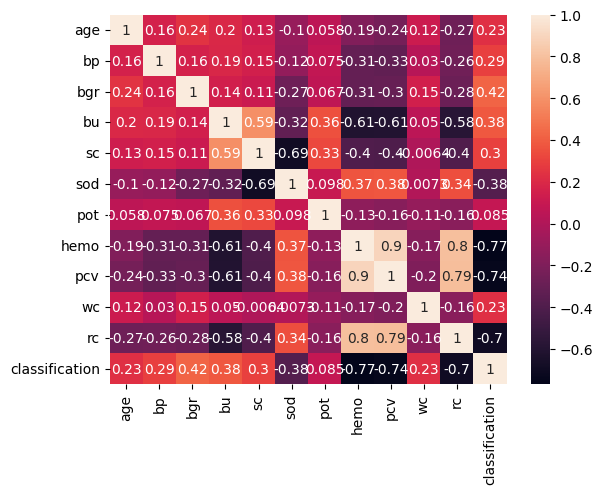

In [116]:
corr=data[num_col].corr()
sns.heatmap(corr,annot=True)

### Filling null values

In [117]:
def random_sampling(feature):
    random_sample=data[feature].dropna().sample(data[feature].isna().sum()) # dropping nulll values and taking the same count of samples
    random_sample.index=data[data[feature].isnull()].index    # taking the index for random sample
    data.loc[data[feature].isnull(),feature]=random_sample   # storing the random sample in place of null values
print(data[num_col].isnull().sum().sort_values(ascending=False))

# replacing null vales with random sampling    
for i in num_col:
    random_sampling(i)                      # we can also replace it with mean if there are low counts of null values
print(data[num_col].isnull().sum())

def replace_with_mode(feature):
    mode=data[feature].mode()[0]
    data[feature]=data[feature].fillna(mode)

for i in catcol:
    replace_with_mode(i)

print(data.isnull().sum())
print(catcol)
print(data.head(20))

rc                131
wc                106
pot                88
sod                87
pcv                71
hemo               52
bgr                44
bu                 19
sc                 17
bp                 12
age                 9
classification      0
dtype: int64
age               0
bp                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
classification    0
dtype: int64
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane       

C:\Users\Vinoth\AppData\Local\Temp\ipykernel_40860\1849060423.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[feature]=data[feature].fillna(mode)


### Encoding the categorical data

In [118]:
le=LabelEncoder()
data[catcol]=data[catcol].apply(le.fit_transform)

### Splitting train and test

In [119]:
X=data.drop(columns='classification',axis=1)
y=data['classification']


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=24)

## Building the model

In [120]:
Model1=LogisticRegression(random_state=24)
Model1.fit(X_train,y_train)
y_pred=Model1.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9
[[23  5]
 [ 3 49]]


c:\Users\Vinoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [121]:
Model2=KNeighborsClassifier()
Model2.fit(X_train,y_train)
y_pred=Model2.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.6625
[[22  6]
 [21 31]]


In [122]:
Model3=GaussianNB()
Model3.fit(X_train,y_train)
y_pred=Model3.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.975
[[28  0]
 [ 2 50]]


In [123]:
Model4=MultinomialNB()
Model4.fit(X_train,y_train)
y_pred=Model4.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8
[[27  1]
 [15 37]]


In [124]:
Model5=SVC(kernel='poly')
Model5.fit(X_train,y_train)
y_pred=Model5.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.65
[[ 0 28]
 [ 0 52]]


In [125]:
Model6=KNeighborsClassifier()
Model6.fit(X_train,y_train)
y_pred=Model6.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.6625
[[22  6]
 [21 31]]


In [126]:
Model7=DecisionTreeClassifier()
Model7.fit(X_train,y_train)
y_pred=Model7.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9375
[[28  0]
 [ 5 47]]


In [127]:
Model8=RandomForestClassifier()
Model8.fit(X_train,y_train)
y_pred=Model8.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

1.0
[[28  0]
 [ 0 52]]


In [128]:
Model9=AdaBoostClassifier()
Model9.fit(X_train,y_train)
y_pred=Model9.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[28  0]
 [ 0 52]]
1.0


c:\Users\Vinoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [129]:
Model10=XGBClassifier()
Model10.fit(X_train,y_train)
y_pred=Model10.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[28  0]
 [ 2 50]]
0.975


##  Hyperparameter tuning


In [130]:
models = {'xgb': Model10, 'rf': Model8,'ab':Model9}

In [131]:
param_grids = {
    'xgb': {
        'xgb__n_estimators': [100, 200, 300],
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.1, 0.01]
    },
    'rf': {
        'rf__n_estimators': [100, 200, 300],
        'rf__max_depth': [None, 5, 10],
        'rf__min_samples_split': [2, 5, 10]
    },
    'ab': {
        'ab__n_estimators': [100, 200, 300],
        
    }
}

In [132]:
pipelines = []

In [133]:
for model_name, model in models.items():
    pipeline = Pipeline([(model_name, model)])
    pipelines.append((model_name, pipeline))

### Perform Grid search for each model

In [134]:
best_models = {}
for model_name, pipeline in pipelines:
    grid_search = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grids[model_name], 
                               cv=5, 
                               scoring='accuracy') 
    grid_search.fit(X_train, y_train) 
    best_models[model_name] = {'model': grid_search.best_estimator_, 
                              'best_params': grid_search.best_params_, 
                              'best_score': grid_search.best_score_}

c:\Users\Vinoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Vinoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Vinoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Vinoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default)

### Best model among all

In [135]:
best_model_name = max(best_models, key=lambda x: best_models[x]['best_score'])
best_model = best_models[best_model_name]['model']
best_params = best_models[best_model_name]['best_params']

In [136]:
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_models[best_model_name]['best_score']}")

Best Model: rf
Best Parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best Score: 0.990625


## Building ANN

In [137]:
from keras.src.models import Sequential
from keras.src.layers import Dense

### Building Model

In [141]:
model=Sequential()
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

### Training the model

In [142]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_train,y_train,batch_size=32,epochs=100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3922 - loss: 790.9453  
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5211 - loss: 91.9696  
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6148 - loss: 139.1759 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5518 - loss: 40.7176 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5798 - loss: 19.6941
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5024 - loss: 14.4741
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4987 - loss: 14.7870 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5891 - loss: 8.1283  
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4559 - loss: 6.1654 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5157 - loss: 7.1431 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5838 - loss: 10.3465 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0

### Fitting the test dataset and testing

In [143]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[27  1]
 [ 9 43]]
0.875
